In [3]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats

In [7]:
sys.path.append('../External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure

In [172]:
file_paths =      ["Pendulum_data/time/file2.dat", "Pendulum_data/time/file3.dat", 
                   "Pendulum_data/time/file4.dat", "Pendulum_data/time/file5.dat",
                   "Pendulum_data/time/file6.dat"]

data = []

for file_path in file_paths:
    temp = np.genfromtxt(file_path, delimiter='')  
    data.append(temp)

In [264]:
# make all arrays same length (data trimming)

data = [array[:25] for array in data] # 25 measurements
swings = np.array(data[0]).T[0] # range from 1 to 25



#period_errors = np.std(data, axis=1).T[1] # error on each individuals sequence of 25 measurements
combined_periods = np.mean(data, axis=0).T[1] # the combined average
#combined_period_errors = np.std(data, axis=0).T[1] / np.sqrt(5) # error on the each averaged datapoint

periods = combined_periods - np.roll(combined_periods, 1) # the average period 
periods[0]    = combined_periods[0]
periods_error = np.std(periods)                           # the error on this average (divide på)
periods = np.mean(periods)

print(periods)

8.575944 0.06603148776152265


In [224]:

def linear(x, a, b):
    return a*x + b

def gauss_pdf(x, mu, sigma) :
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

x_data, y_data, y_errors = swings, periods, combined_period_errors

def chi2_linear(a, b):
    y_model = linear(x_data, a, b)
    chi2 = np.sum(((y_data - y_model) / y_errors) ** 2)
    return chi2


def chi2_gauss(a, b):
    y_model = gauss_pdf(x_data, mu, sigma)
    chi2 = np.sum(((y_data - y_model) / y_errors) ** 2)
    return chi2

# Period finding

a = 7.51  ± 0.01 , b = -0.05 ± 0.10


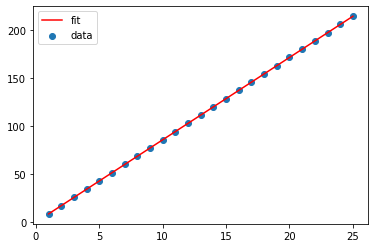

In [228]:
chi2_linear_fit = Minuit(chi2_linear, a = 1,b = 0)
chi2_linear_fit.errordef = 1.0
chi2_linear_fit.migrad()
fit_a =           chi2_linear_fit.values["a"]
fit_b =           chi2_linear_fit.values["b"]
fit_a_err =       chi2_linear_fit.errors["a"]
fit_b_err =       chi2_linear_fit.errors["b"]

print(f'a = {fit_slope:.2f}  \u00B1 {fit_a_err:.2f} , b = {fit_intercept:.2f} \u00B1 {fit_b_err:.2f}')
plt.scatter(x_data, y_data, label = 'data')
plt.plot(x_data, linear(x_data, fit_a, fit_b), label = 'fit', color = 'red')
plt.legend()
plt.show()

# Histrogram 

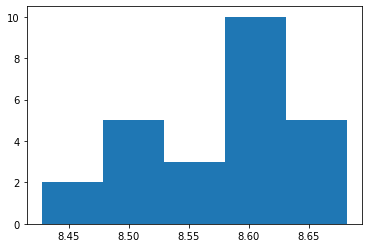

In [255]:
Nbins = 5
xmin, xmax = 5, 10
binwidth = (xmax-xmin)/Nbins


test = np.array(y_data - np.roll(y_data, 1))
test[0] = y_data[0]


plt.hist(test, bins = Nbins);

counts, bin_edges = np.histogram(test, bins=Nbins, range=(xmin, xmax))

x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)



../External_Functions\ExternalFunctions.py:247: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])
../External_Functions\ExternalFunctions.py:273: UserWarning: x is really small return 0
  warnings.warn('x is really small return 0')
../External_Functions\ExternalFunctions.py:279: RuntimeWarning: invalid value encountered in log1p
  return -x*np.log1p( (x-y) / y )
../External_Functions\ExternalFunctions.py:279: RuntimeWarning: divide by zero encountered in double_scalars
  return -x*np.log1p( (x-y) / y )


a = 8.62  ± 0.04 , b = 0.01 ± 0.03
p_chi2 = 0.012021676253634074


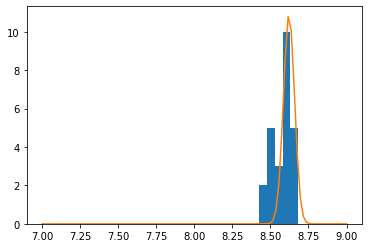

In [256]:
# make fit
binned_fit = BinnedLH(gauss_pdf, test, bins=Nbins, bound=(xmin, xmax), extended=True)
binned_fit = Minuit(binned_fit, mu=8, sigma=0.3)
binned_fit.errordef = 0.5     # Value for likelihood fits
binned_fit.migrad();           # Perform the actual fit

# extract fit values
mu, sigma = binned_fit.values[:]
mu_err, sigma_err = binned_fit.errors[:]
binned_chi = binned_fit.fval

# plot results
X = np.linspace(7, 9, 100)
plt.hist(test, bins = Nbins)
plt.plot(X, gauss_pdf(X, mu, sigma))

# print results
print(f'a = {mu:.2f}  \u00B1 {sigma:.2f} , b = {mu_err:.2f} \u00B1 {sigma_err:.2f}')
print(f'p_chi2 = {stats.chi2.sf(binned_chi, np.sum(test > 0) -  binned_fit.nfit)}')


plt.show()